<H4>Installations and imports</H4>

In [190]:
!pip3 install --upgrade 'google-cloud-bigquery[pandas]' --user
!pip3 install --upgrade pip --user
!pip3 install scikit-learn
!pip3 install google-cloud-bigquery-storage
!pip3 install matplotlib
!pip3 install kneed
%load_ext google.cloud.bigquery


import os
import numpy
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing



Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid t

<H2>The approach</H2>
We approach the data with the aim of understanding the underlying distribution of the sample values for each label within a metric. To do so, we wish to understand where natural clusters form within the data in order to identify potential shifts in the distribution of data over time. We decided to employ the use of k-means clustering because
<ol>
<li>It is relatively straightforward to implement</li>
<li>It scales well with large datasets</li>
<li>It can deal with clusters of varying shapes and sizes</li>
<li>Provides clear visual indicators of movement</li>
</ol>


<H3> K-means Clustering </H3>
The K-means clustering approach takes unlabelled data and splits it into a set number of (k) clusters. For each label dataset we will find the optimal number of clusters by using the elbow and silhoutte methods. 
<H4> Elbow method </H4>
This is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. The elbow is the cutoff point of the curve after which any increase in clusters doesn't make a significant impact. The idea is that the first few clusters provide the bulk of the information (explain a lot of variation), since the data naturally forms these set groups (so these clusters are necessary), but once the number of clusters exceeds the natural groupings, the added information will drop sharply, because it is just subdividing the actual groups. At this point there will appear a sharp elbow in the graph and this point returns the optimal k value for our k-means clustering.



<H4> Silhoutte method </H4>
We use the Silhoutte score to find out the quality of clustering for a set of data. It is used to measure how dense and well-separated the clusters are.
The value of the Silhouette score varies from -1 to 1. 1 indicates dense clustering with well separated clusters. 0 indicates overlapping clusters with unclear cluster distinction and samples very close to the decision boundary of the neighboring clusters. A negative score suggests the data may have been assigned to incorrect clusters. 

For this notebook, we find the silhoutte score for a range of differnt k values. Our aim is to find which k value (number of clusters) results in the highest silhoutte score. This then becomes the k value that we use in the k-means clustering.

Literature claims the silhoutte method to be more reliable than the Elbow method so we rely on the value from the silhoutte method to inform our k value decision.


<H3> Sliding windows </H3>
To increase our sample size and reduce the effects of noise at an individual revision, we create sliding windows. A window spans 50 revisions. We agregate all the sample values within each window. 
Then we can track how the centroid of each cluster shifts over multiple revision windows.


The data we will be working with is currently being stored in the chromeperf-datalab bigquery project. </br>
The raw data is structured in the following way 
-revision	INTEGER	 --> This is the unique revision number for the build	
- value	FLOAT	 --> This is generally the mean of sample_values	
- std_error	FLOAT	 --> Standard error for value	
- timestamp	TIMESTAMP	 --> This is the time the data was uploaded to the dashboard	
- master	STRING --> Project	
- bot	STRING --> Platform	
- test	STRING -->Measurement data with the added information about the ---- platform and the project --> Project/platform/measurement	
- properties	STRING --> Properties of the test	 
- sample_values	FLOAT -->An array of values from multiple iterations of the specific story.	
- measurement	STRING	 --> The exact metric being measured. The structure of the measurement usually is:
</br>benchmark/metric/label/story	
metrics have several label groups and each of those labels have individual stories to test.	

In [191]:
bigquery_client = bigquery.Client(project='chromeperf-datalab')
#can change this later to be arrays so we can loop through them for multiple different combinations of metric, bot and platform
case = "ChromiumPerf","linux-perf","system_health.common_desktop/timeToFirstPaint/%/%"

sql = """
SELECT SPLIT(measurement, '/')[SAFE_OFFSET(2)] label, revision, value, std_error, sample_values
FROM `chromeperf.chromeperf_dashboard_data.rows`
WHERE DATE(timestamp) >= DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)
AND master = "{MASTER}"
AND bot = "{BOT}"
AND measurement LIKE "{METRIC}"
ORDER BY revision ASC 
"""

def fetch_sample_data(case):
  MASTER, BOT, METRIC = case
  return bigquery_client.query(sql.format(**locals())).result().to_dataframe()

df= fetch_sample_data(case)
print(df.head(n=7))
print(type(df))

          label  revision    value  std_error      sample_values
0    load_media    840369  162.897   0.000000          [162.897]
1     load_news    840369  155.651   0.000000          [155.651]
2    load_games    840369  164.748   0.000000          [164.748]
3     load_news    840369  115.467  25.079673  [97.733, 133.201]
4     load_news    840369  586.383   0.000000          [586.383]
5     load_news    840369  313.084   0.000000          [313.084]
6  browse_media    840369  188.049   0.000000          [188.049]
<class 'pandas.core.frame.DataFrame'>


The query determines the data that we will be pulling from bigquery. For this POC we will be analysing the timeToFirstPaint metric over the last 30 days. We have pulled out labels from the measurement field.

<H2> Data Preprocessing </H2>

In [192]:
#Organising the data to be grouped by label and revision number
label_group = df.groupby(['label','revision'])['sample_values'].apply(pd.Series.to_numpy)
groups = tuple(zip(*label_group.keys()))[0]
#get an array of the keys in the dictionary
label_names = numpy.unique(groups)

centroid_dictionary = {}

"""
This will create a dictionary of centroid clusters for each 
label for the current metric
"""
for label in label_names:

    centroid_x = []
    centroid_y = []
    revisions_dictionary = label_group[label]
    revisions = list(revisions_dictionary.keys())
    window_size = 50
    window_number = 0
    i=0
    window_dictionary = {}

    
    #Finding the k-means clustering over each window of size 50 revsions
    while i in range(0,len(revisions)-(window_size+1)):
        selection = revisions[i:i+window_size]
        frames = []
        
        for revision_label in selection:
            sample_values = numpy.concatenate(revisions_dictionary[revision_label], axis = 0)
            dataset = pd.DataFrame({'Revision': revision_label, 'Values': sample_values[0:]})
            frames.append(dataset)

        result = pd.concat(frames)
        numpy_result = result.to_numpy()
        
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform([ (y, y) for _,y in numpy_result ])

        kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=10,
        max_iter=300,
        random_state=42
                        )
        kmeans.fit(scaled_features)

        kmeans_kwargs = {
            "init": "random",
            "n_init": 10,
            "max_iter": 300,
            "random_state": 42,
        }

        # A list holds the SSE values for each k
        sse = []
        
        """
        ELBOW METHOD
        """ 
        for k in range(1, 11): #Testing the different k values 
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(scaled_features)
            sse.append(kmeans.inertia_)
        
        #TODO: insert action item here for k value from elbow so we can do a comparison
            
        """
        SILHOUTTE METHOD
        """
        # A list holds the silhouette coefficients for each k
        silhouette_coefficients = []
        
        # We start at 2 clusters for silhouette coefficient
        for k in range(2, 11):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(scaled_features)
            score = silhouette_score(scaled_features, kmeans.labels_)
            silhouette_coefficients.append(score)

        #from the silhoutte method we get the k_value
        k_value = numpy.argmax(silhouette_coefficients)+2

        kmeans_optimised = KMeans(n_clusters = k_value).fit(numpy_result)
        centers = numpy.array(kmeans_optimised.cluster_centers_)
        x, y = zip(*centers)
        centroid_x = centroid_x + ([window_number]*k_value)
        centroid_y = centroid_y + list(y)

        window_dictionary[window_number] = list(y)
        i+= (window_size-10) 
        window_number +=1
    centroid_dictionary[label] = window_dictionary


<H2> Centroid plots for each label </H2>

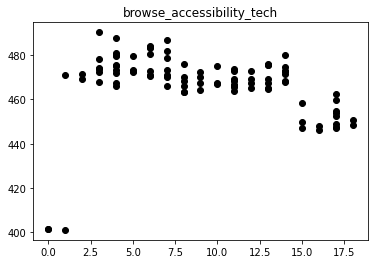

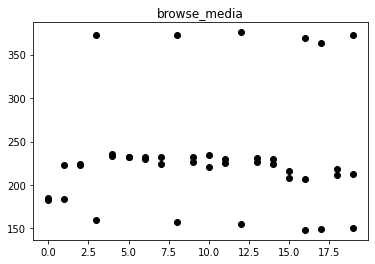

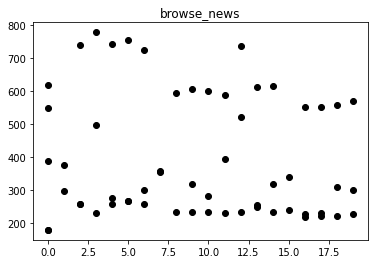

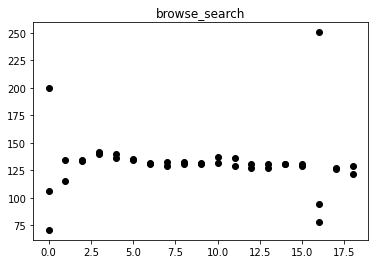

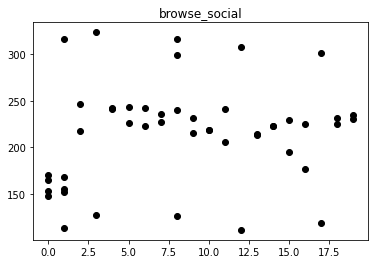

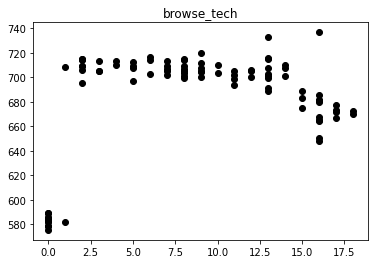

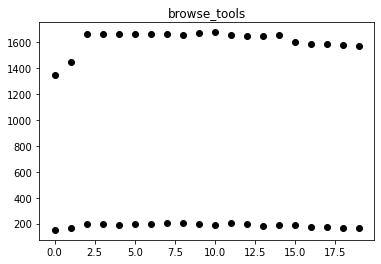

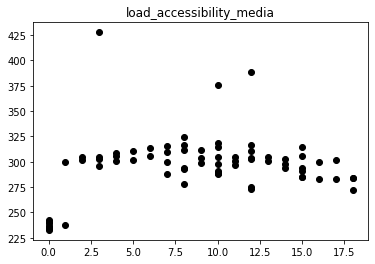

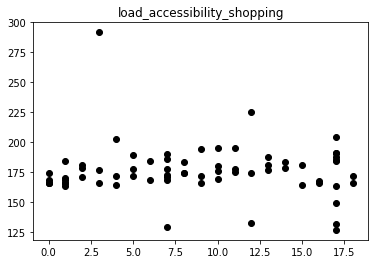

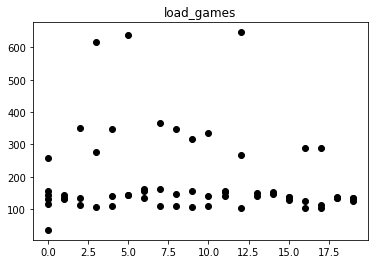

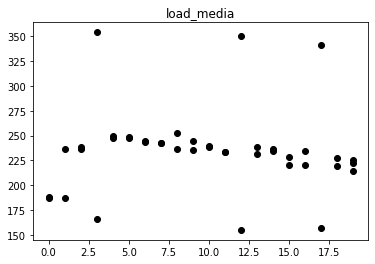

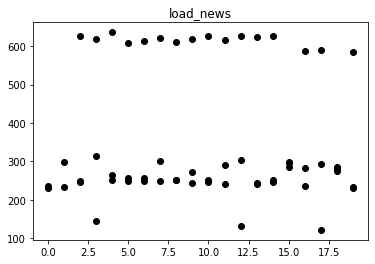

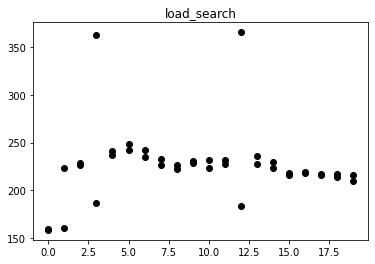

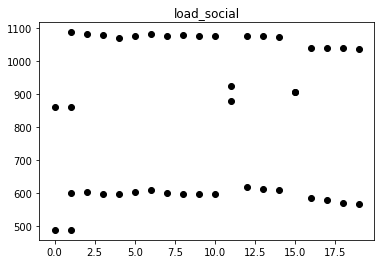

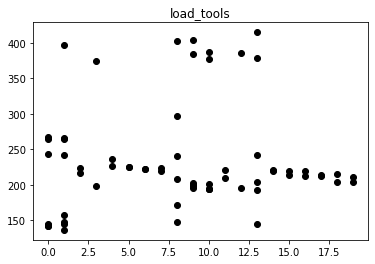

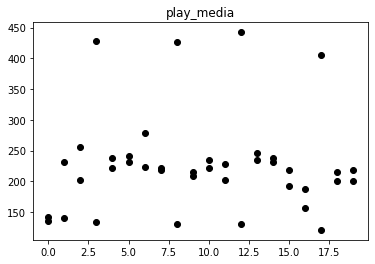

In [193]:
for key in centroid_dictionary:
    
    label_dict = centroid_dictionary[key].copy()
    x_axis = []
    y_axis = []
  
    for window in label_dict:
        values = label_dict[window]
        window_array = [window]*len(values)
       
        if len(x_axis)==0:
            x_axis = window_array
            y_axis = values
        else:
            x_axis = x_axis + window_array
            y_axis = y_axis + values

    plt.figure()
    plt.scatter(x_axis,y_axis,color='black')
    plt.title(key)
    plt.show()